# Using the BFGS and L-BFGS optimizer for all EGB data.

Source for the cells below: https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993

In [ ]:
"""An example of using tfp.optimizer.lbfgs_minimize to optimize a TensorFlow model.
This code shows a naive way to wrap a tf.keras.Model and optimize it with the L-BFGS
optimizer from TensorFlow Probability.
Python interpreter version: 3.6.9
TensorFlow version: 2.0.0
TensorFlow Probability version: 0.8.0
NumPy version: 1.17.2
Matplotlib version: 3.1.1
"""
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        # COME HERE TO PRINT
        # tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

# def plot_helper(inputs, outputs, title, fname):
#     """Plot helper"""
#     pyplot.figure()
#     pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
#     pyplot.xlabel("x")
#     pyplot.ylabel("y")
#     pyplot.title(title)
#     pyplot.colorbar()
#     pyplot.savefig(fname)

In [ ]:
# if __name__ == "__main__":

#     # use float64 by default
#     tf.keras.backend.set_floatx("float64")

#     # prepare training data
#     x_1d = numpy.linspace(-1., 1., 11)
#     x1, x2 = numpy.meshgrid(x_1d, x_1d)
#     inps = numpy.stack((x1.flatten(), x2.flatten()), 1)
#     outs = numpy.reshape(inps[:, 0]**2+inps[:, 1]**2, (x_1d.size**2, 1))

#     # prepare prediction model, loss function, and the function passed to L-BFGS solver
#     pred_model = tf.keras.Sequential(
#         [tf.keras.Input(shape=[2,]),
#          tf.keras.layers.Dense(64, "tanh"),
#          tf.keras.layers.Dense(64, "tanh"),
#          tf.keras.layers.Dense(1, None)])

#     loss_fun = tf.keras.losses.MeanSquaredError()
#     func = function_factory(pred_model, loss_fun, inps, outs)

#     # convert initial model parameters to a 1D tf.Tensor
#     init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)

#     # train the model with L-BFGS solver
#     results = tfp.optimizer.lbfgs_minimize(
#         value_and_gradients_function=func, initial_position=init_params, max_iterations=500)

#     # after training, the final optimized parameters are still in results.position
#     # so we have to manually put them back to the model
#     func.assign_new_model_parameters(results.position)

#     # do some prediction
#     pred_outs = pred_model.predict(inps)
#     err = numpy.abs(pred_outs-outs)
#     print("L2-error norm: {}".format(numpy.linalg.norm(err)/numpy.sqrt(11)))

#     # plot figures
#     plot_helper(inps, outs, "Exact solution", "ext_soln.png")
#     plot_helper(inps, pred_outs, "Predicted solution", "pred_soln.png")
#     plot_helper(inps, err, "Absolute error", "abs_err.png")
#     pyplot.show()

#     # print out history
#     print("\n"+"="*80)
#     print("History")
#     print("="*80)
#     print(*func.history, sep='\n')

# Change the model and the Data

In [ ]:
import pandas as pd
from google.colab import files
import io

In [ ]:
uploaded = files.upload()

Saving MRpa_data.csv to MRpa_data.csv


In [ ]:
mrpa = pd.read_csv(io.BytesIO(uploaded['MRpa_data.csv']))
mrpa

,Unnamed: 0,M,R,p_c,a
0,0,0.337989,12.889804,0.100000,-0.4
1,1,0.343933,12.840271,0.102555,-0.4
2,2,0.349966,12.792721,0.105175,-0.4
3,3,0.356088,12.747087,0.107861,-0.4
4,4,0.362285,12.703496,0.110617,-0.4
...,...,...,...,...,...
10195,10195,2.661345,9.876440,21.375766,9.2
10196,10196,2.660851,9.842380,21.972021,9.2
10197,10197,2.660204,9.808243,22.584908,9.2
10198,10198,2.659405,9.774034,23.214891,9.2


In [ ]:
data = mrpa.copy()

In [ ]:
datalog = pd.DataFrame({})
datalog['p_c'] = numpy.log10(data.p_c.values)
datalog['M'] = numpy.log10(data.M.values)
datalog['R'] = numpy.log10(data.R.values)
datalog['a'] = data.a.values
data = datalog
data

,p_c,M,R,a
0,-1.000000,-0.471098,1.110246,-0.4
1,-0.989045,-0.463526,1.108574,-0.4
2,-0.978089,-0.455974,1.106963,-0.4
3,-0.967134,-0.448443,1.105411,-0.4
4,-0.956179,-0.440950,1.103923,-0.4
...,...,...,...,...
10195,1.329922,0.425101,0.994600,9.2
10196,1.341870,0.425021,0.993100,9.2
10197,1.353818,0.424915,0.991591,9.2
10198,1.365767,0.424784,0.990074,9.2


In [ ]:
uploaded = files.upload()

Saving alpha_list.csv to alpha_list.csv


In [ ]:
df_alpha = pd.read_csv(io.BytesIO(uploaded['alpha_list.csv']))
df_alpha.head()

,Unnamed: 0,a
0,0,-0.4
1,1,-10.0
2,2,-2.0
3,3,-3.6
4,4,-5.2


In [ ]:
alpha_list = list(df_alpha.a.values)

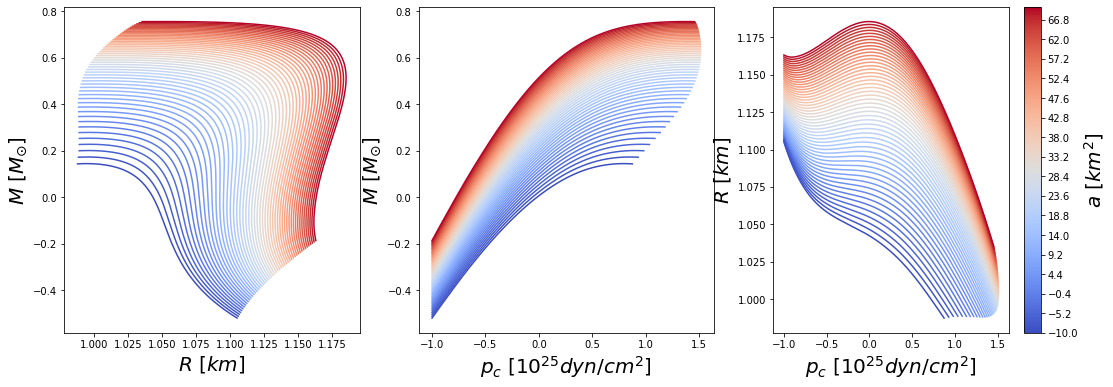

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# Units
units = {
    'M'  :'M_{\odot}',
    'R'  :'km',
    'p_c':'10^{25} dyn/cm^2',
    'a'  :'km^2'
}

df = data.copy()
# All linear
n_lines = int(len(df)/200)

a = alpha_list
clrs = a.copy()
clrs.sort()

norm = mpl.colors.Normalize(vmin=min(a), vmax=max(a))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

fig, ax = plt.subplots(1,3, figsize = (18,6))
for i in range(len(alpha_list)):
    temp = df[df['a'] == alpha_list[i]]
    
    r  = temp.R.values
    m  = temp.M.values
    pc = temp.p_c.values
    
    ax[0].plot(r, m, color=cmap.to_rgba(alpha_list[i]))
    # ax[0].tick_params(axis='both', which='major', labelsize=10)
    
    ax[1].plot(pc, m, color=cmap.to_rgba(alpha_list[i]))
    
    ax[2].plot(pc, r, color=cmap.to_rgba(alpha_list[i]))


cbar = fig.colorbar(cmap, ticks=clrs[::3])
cbar.set_label('$a$ [$km^2$]', fontsize = 20, rotation=90)

name = "$R$ [$"+units["R"]+"$]"
ax[0].set_xlabel(name, fontsize = 20)
name = "$M$ [$"+units["M"]+"$]"
ax[0].set_ylabel(name, fontsize = 20)

name = "$p_c$ [$"+units["p_c"]+"$]"
ax[1].set_xlabel(name, fontsize = 20)
name = "$M$ [$"+units["M"]+"$]"
ax[1].set_ylabel(name, fontsize = 20)

name = "$p_c$ [$"+units["p_c"]+"$]"
ax[2].set_xlabel(name, fontsize = 20)
name = "$R$ [$"+units["R"]+"$]"
ax[2].set_ylabel(name, fontsize = 20)

plt.show()

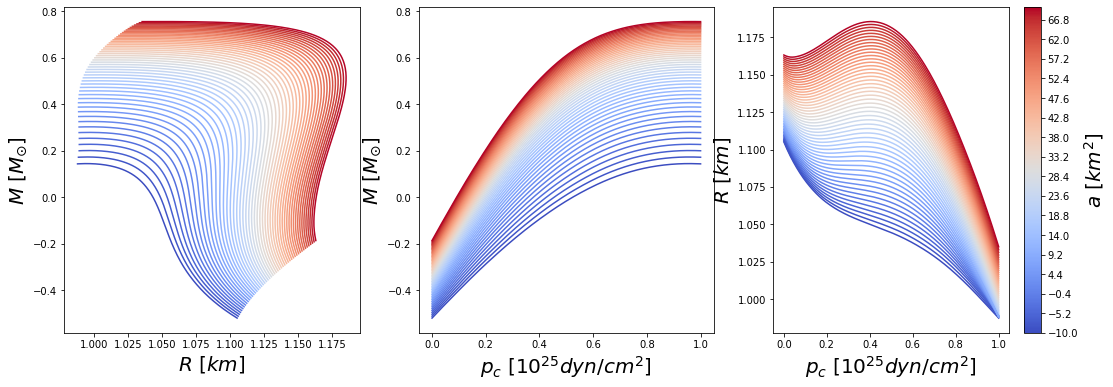

In [ ]:
df = data.copy()
# All linear
n_lines = int(len(df)/200)

a = alpha_list
clrs = a.copy()
clrs.sort()

norm = mpl.colors.Normalize(vmin=min(a), vmax=max(a))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

norm_df = pd.DataFrame({})

fig, ax = plt.subplots(1,3, figsize = (18,6))
for i in range(len(alpha_list)):
    temp = df[df['a'] == alpha_list[i]].copy()
    
    r  = temp.R.values
    m  = temp.M.values
    pc = temp.p_c.values
    
    pc = (pc - min(pc))/(max(pc)-min(pc))

    x  = pc
    y1 = r
    y2 = m

    ax[0].plot(y1, y2, color=cmap.to_rgba(alpha_list[i]))
    # ax[0].tick_params(axis='both', which='major', labelsize=10)
    
    ax[1].plot(x, y2, color=cmap.to_rgba(alpha_list[i]))
    
    ax[2].plot(x, y1, color=cmap.to_rgba(alpha_list[i]))

    temp['p_n'] = pc

    norm_df = pd.concat([norm_df,temp],ignore_index = True)

cbar = fig.colorbar(cmap, ticks=clrs[::3])
cbar.set_label('$a$ [$km^2$]', fontsize = 20, rotation=90)

name = "$R$ [$"+units["R"]+"$]"
ax[0].set_xlabel(name, fontsize = 20)
name = "$M$ [$"+units["M"]+"$]"
ax[0].set_ylabel(name, fontsize = 20)

name = "$p_c$ [$"+units["p_c"]+"$]"
ax[1].set_xlabel(name, fontsize = 20)
name = "$M$ [$"+units["M"]+"$]"
ax[1].set_ylabel(name, fontsize = 20)

name = "$p_c$ [$"+units["p_c"]+"$]"
ax[2].set_xlabel(name, fontsize = 20)
name = "$R$ [$"+units["R"]+"$]"
ax[2].set_ylabel(name, fontsize = 20)

plt.show()

In [ ]:
### NOTE: PUT SAME COLORBAR IN 1 AND 2

def contour(df_c, var):
    from matplotlib import ticker, cm
    import matplotlib.pyplot as plt
    import numpy as np

    from matplotlib.cm import ScalarMappable

    pxl = 1000

    units = {
    'M'  :'M_{\odot}',
    'R'  :'km',
    'p_c':'10^{25} dyn/cm^2',
    'a'  :'km^2',
    'p_n':'arbitrary'
    }

    vars = {"x"  : "p_n",
            "y"  : "a",
            "z1" : var,
            "z2" : var+"_pred"}

    fig, ax = plt.subplots(1,3, figsize = (24,6))

    x = df_c[vars['x']].values[:200]
    y = df_c[vars['y']].values[::200]
    z1 = 10**df_c[vars['z1']].values.reshape((51,200))
    z2 = 10**df_c[vars['z2']].values.reshape((51,200))


    cs0 = ax[0].contourf(x, y, z1, pxl, cmap=cm.coolwarm)
    cs1 = ax[1].contourf(x, y, z2, levels=cs0.levels, cmap=cm.coolwarm, extend='both')#, vmin=np.min(z1), vmax=np.max(z1))
    cs2 = ax[2].contourf(x, y, numpy.abs(z2-z1)/z1*100, pxl, cmap=cm.coolwarm)

    for j in range(3):
        name = "$p_n$ [$"+units["p_n"]+"$]"
        ax[j].set_xlabel(name, fontsize = 20)
        name = "$a$ [$"+units["a"]+"$]"
        ax[j].set_ylabel(name, fontsize = 20)
    


    cs1.cmap.set_under('red')
    cs1.cmap.set_over('blue')

    # ax[1].set_ylabel(name, fontsize = 20)

    # fig.colorbar(cntr1, ax=ax1)

    cbar0 = fig.colorbar(cs0, ax = ax[0])
    name = "$"+var+"$ [$"+units[var]+"$]"
    cbar0.set_label(name, rotation=90, fontsize = 20)

    cbar1 = fig.colorbar(cs1, ax = ax[1])
    name = "$"+var+"_{pred}$ [$"+units[var]+"$]"
    cbar1.set_label(name, rotation=90, fontsize = 20)

    cbar2 = fig.colorbar(cs2, ax = ax[2])
    name = "$APE$ [%]"
    cbar2.set_label(name, rotation=90, fontsize = 20)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

## For one alpha

In [ ]:
alpha_list.sort()
temp = df[df['a'] == alpha_list[23]]
temp.reset_index(drop = True, inplace = True)
temp

,p_c,M,R,a
0,-1.000000,-0.348498,1.129117,26.8
1,-0.987421,-0.338819,1.127958,26.8
2,-0.974842,-0.329185,1.126872,26.8
3,-0.962263,-0.319575,1.125852,26.8
4,-0.949684,-0.310016,1.124898,26.8
...,...,...,...,...
195,1.452881,0.571498,1.004748,26.8
196,1.465460,0.571442,1.002764,26.8
197,1.478039,0.571368,1.000758,26.8
198,1.490618,0.571275,0.998732,26.8


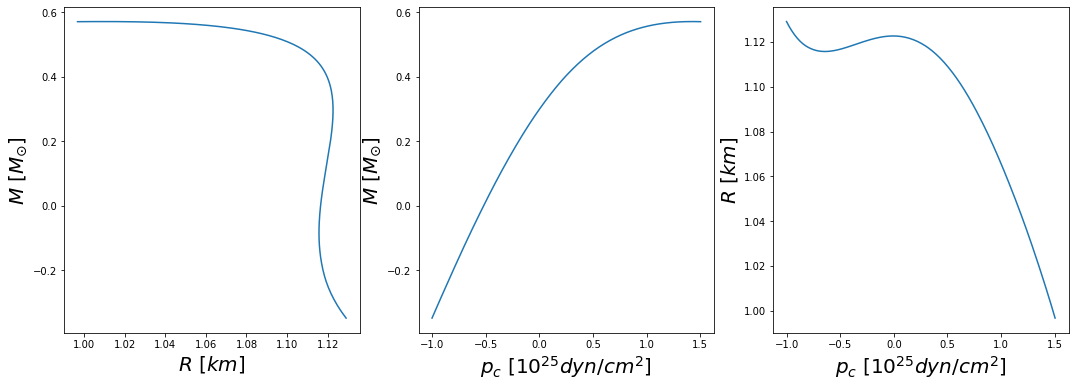

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,6))

r  = temp.R.values
m  = temp.M.values
pc = temp.p_c.values

ax[0].plot(r, m)
# ax[0].tick_params(axis='both', which='major', labelsize=10)

ax[1].plot(pc, m)

ax[2].plot(pc, r)

name = "$R$ [$"+units["R"]+"$]"
ax[0].set_xlabel(name, fontsize = 20)
name = "$M$ [$"+units["M"]+"$]"
ax[0].set_ylabel(name, fontsize = 20)

name = "$p_c$ [$"+units["p_c"]+"$]"
ax[1].set_xlabel(name, fontsize = 20)
name = "$M$ [$"+units["M"]+"$]"
ax[1].set_ylabel(name, fontsize = 20)

name = "$p_c$ [$"+units["p_c"]+"$]"
ax[2].set_xlabel(name, fontsize = 20)
name = "$R$ [$"+units["R"]+"$]"
ax[2].set_ylabel(name, fontsize = 20)

plt.show()

In [ ]:
data = temp.copy()
data

,p_c,M,R,a
0,-1.000000,-0.348498,1.129117,26.8
1,-0.987421,-0.338819,1.127958,26.8
2,-0.974842,-0.329185,1.126872,26.8
3,-0.962263,-0.319575,1.125852,26.8
4,-0.949684,-0.310016,1.124898,26.8
...,...,...,...,...
195,1.452881,0.571498,1.004748,26.8
196,1.465460,0.571442,1.002764,26.8
197,1.478039,0.571368,1.000758,26.8
198,1.490618,0.571275,0.998732,26.8


## For all data

In [ ]:
# My func
def prepare(data,
            Predictors,
            TargetVariable,
            scale,
            talk):
    """
    

    Parameters
    ----------
    data : DataFrame
        Data to be prepared for ANN.

    Returns
    -------
    X_train : array
        Input variables of Training set.
    X_test  : array
        Input variables of Testing set.
    y_train : array
        Output variables of Training set.
    y_test  : array
        Output variables of Testing set
    PredictorScalerFit : StandardScaler
        Predictor Scaler.
    TargetVarScalerFit : StandardScaler
        Target Variable Scaler.

    """
    # data = data.sample(frac=1).reset_index(drop=True)
    
    
    X=data[Predictors].values
    y=data[TargetVariable].values
    
    
    from sklearn.preprocessing import StandardScaler
    PredictorScaler=StandardScaler()
    PredictorScalerFit=PredictorScaler.fit(X)
    X=PredictorScalerFit.transform(X)

    if scale:
        TargetVarScaler=StandardScaler()
        TargetVarScalerFit=TargetVarScaler.fit(y)
        y=TargetVarScalerFit.transform(y)
    else:
        TargetVarScalerFit = None

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    
    if talk:
        print(X_train.shape)
        print(y_train.shape)
        print(X_test.shape)
        print(y_test.shape)
    return X_train, X_test, y_train, y_test, PredictorScalerFit, TargetVarScalerFit, data

def plot_2D(TestingData,
            tr_history,
            eps,
            bat,
            PD,
            neur_list,
            activation_func_list,
            layers,
            extra):
  
    import numpy as np
    
    units = {
    'M'  :'M_{\odot}',
    'R'  :'km',
    'p_c':'10^{25} dyn/cm^2',
    'a'  :'km^2'}
    
    colr1 = 'linen'
    if extra:
        x = TestingData.p_c.values
        
        y1 = TestingData.M.values
        y2 = TestingData.M_pred.values
        
        z1 = TestingData.R.values
        z2 = TestingData.R_pred.values

        fig, ax = plt.subplots(1, 2, figsize=(18,5))
        ax[0].scatter(x,y1, color = 'm', label = 'True', s = 5)
        ax[0].scatter(x,y2, color = colr1, label = 'Predicted', s = 5)
        ax[0].legend()
        ax[0].set_title("Mass fitting")
        
        ax[1].scatter(x,z1, color = 'm', label = 'True', s = 5)
        ax[1].scatter(x,z2, color = colr1, label = 'Predicted', s = 5)
        ax[1].legend()
        ax[1].set_title("Radius fitting")

        # Naming
        name = "$p_c$ [$"+units["p_c"]+"$]"
        ax[0].set_xlabel(name)
        name = "$M$ [$"+units["M"]+"$]"
        ax[0].set_ylabel(name)

        name = "$p_c$ [$"+units["p_c"]+"$]"
        ax[1].set_xlabel(name)
        name = "$R$ [$"+units["R"]+"$]"
        ax[1].set_ylabel(name)

        fig.suptitle("Extra plot")

        plt.show()
    else:
        x1 = 10**TestingData.R.values
        y1 = 10**TestingData.M.values
    
        x2 = 10**TestingData.R_pred.values
        y2 = 10**TestingData.M_pred.values
    
        fig, ax = plt.subplots(1, 3, figsize=(18,5))
        ax[0].scatter(x1,y1, color = 'm', label = 'True', s = 5)
        ax[0].scatter(x2,y2, color = colr1, label = 'Predicted', s = 5)
        ax[0].legend()
        ax[0].set_xlabel('$ R \ [km] $')
        ax[0].set_ylabel('$ M \ [M_{\odot}] $')
        ax[0].set_title("Testing Data")
    
    
        # val_loss_list = tr_history['val_loss']
        loss_list     = tr_history
        epos          = np.linspace(1,eps,eps)
        ax[1].semilogy(epos, loss_list    , label = 'Training loss')
        # ax[1].semilogy(epos, val_loss_list, label = 'Validation loss')
        ax[1].set_xlabel('Iterations')
        ax[1].set_ylabel('Loss per iteration')
        ax[1].legend()
        ax[1].set_title("Mean Square Error")
    
    
    
    
        ax[2].semilogy(PD, label = 'Testing set')
        ax[2].semilogy((10**(-1))*np.ones(len(PD)), '--')
        ax[2].semilogy((10**(-2))*np.ones(len(PD)), '--')
        ax[2].set_xlabel('Points')
        ax[2].set_ylabel('Percentage Distance (%)')
        ax[2].legend()
        ax[2].set_title("Percentage Distance")
    
        # Naming
        name_neur = str(neur_list[0]) + " "
        name_act  = str(activation_func_list[0]) + " "
        for indx in range(1,layers):
            name_neur = name_neur + str(neur_list[indx]) + " "
            name_act  = name_act  + str(activation_func_list[indx]) + " "
    
        name_bat  = str(bat)
        name_eps  = str(eps)
    
        fig.suptitle("Neurons: "+name_neur+
                  " / Activation functions: "+name_act+
                  " / Batch: "+name_bat+
                  " / Iterations:"+name_eps)
    
        plt.show()
    return

In [ ]:
X_train, X_test, y_train, y_test, PredictorScalerFit, TargetVarScalerFit, data = prepare( data       = data,
                                                                                          Predictors = ['p_c','a'],
                                                                                          TargetVariable = ['M','R'],
                                                                                          scale      = True,
                                                                                          talk       = True)

(7140, 2)
(7140, 2)
(3060, 2)
(3060, 2)


96/96 [==============================] - 0s 1ms/step
L2-error norm: 0.0023231504578341035


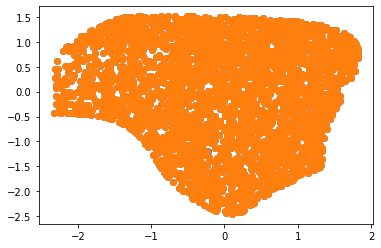


History


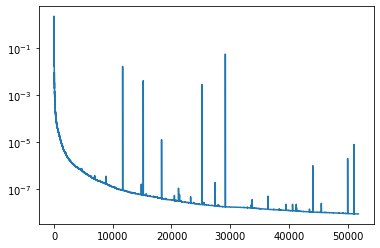

In [ ]:
# use float64 by default
tf.keras.backend.set_floatx("float64")

# prepare training data

inps = X_train
outs = y_train

# prepare prediction model, loss function, and the function passed to L-BFGS solver
# pred_model = tf.keras.Sequential(
#     [tf.keras.Input(shape=[1,]),
#       tf.keras.layers.Dense(25, "tanh"),
#       tf.keras.layers.Dense(35, "relu"),
#       tf.keras.layers.Dense(45, "tanh"),
#       tf.keras.layers.Dense(35, "relu"),
#       tf.keras.layers.Dense(25, "tanh"),
#       tf.keras.layers.Dense(2, None)])

pred_model = tf.keras.Sequential(
    [tf.keras.Input(shape=[2,]),
      tf.keras.layers.Dense(25, "tanh"),
      tf.keras.layers.Dense(35, "relu"),
      tf.keras.layers.Dense(25, "tanh"),
      tf.keras.layers.Dense(2, None)])


loss_fun = tf.keras.losses.MeanSquaredError()
func = function_factory(pred_model, loss_fun, inps, outs)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.bfgs_minimize(
    value_and_gradients_function=func, initial_position=init_params, max_iterations=30000)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# do some prediction
test_inps = X_test
test_outs = y_test
pred_outs = pred_model.predict(test_inps)
err = numpy.abs(pred_outs-test_outs)
print("L2-error norm: {}".format(numpy.linalg.norm(err)/numpy.sqrt(11)))

# plot figures
x1 = test_outs.T[1]
y1 = test_outs.T[0]
plt.scatter (x1,y1)
x2 = pred_outs.T[1]
y2 = pred_outs.T[0]
plt.scatter (x2,y2)

plt.show()

# plt.scatter(inps, outs, "Exact solution", "ext_soln.png")
# plot_helper(inps, pred_outs, "Predicted solution", "pred_soln.png")
# plot_helper(inps, err, "Absolute error", "abs_err.png")
# pyplot.show()

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
# print(*func.history, sep='\n')
loss_lista = []
for metr in func.history:
    loss_lista.append(float(metr))
plt.semilogy(loss_lista)
plt.show()

In [ ]:
TestingData           = pd.DataFrame({})
TestingData['a']      = PredictorScalerFit.inverse_transform(X_test).T[1]
TestingData['p_c']    = PredictorScalerFit.inverse_transform(X_test).T[0]


real                  = TargetVarScalerFit.inverse_transform(test_outs)
pred                  = TargetVarScalerFit.inverse_transform(pred_outs)

TestingData['M']      = real.T[0]
TestingData['M_pred'] = pred.T[0]

TestingData['R']      = real.T[1]
TestingData['R_pred'] = pred.T[1]

PD                    = 100*numpy.sqrt((10**TestingData.M.values - 10**TestingData.M_pred.values)**2 + (10**TestingData.R.values - 10**TestingData.R_pred.values)**2)/numpy.sqrt(10**TestingData.M.values**2 + 10**TestingData.R.values**2)

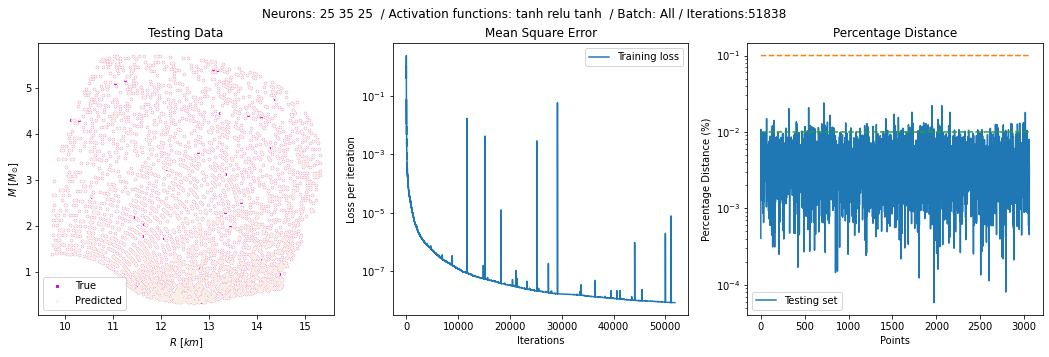

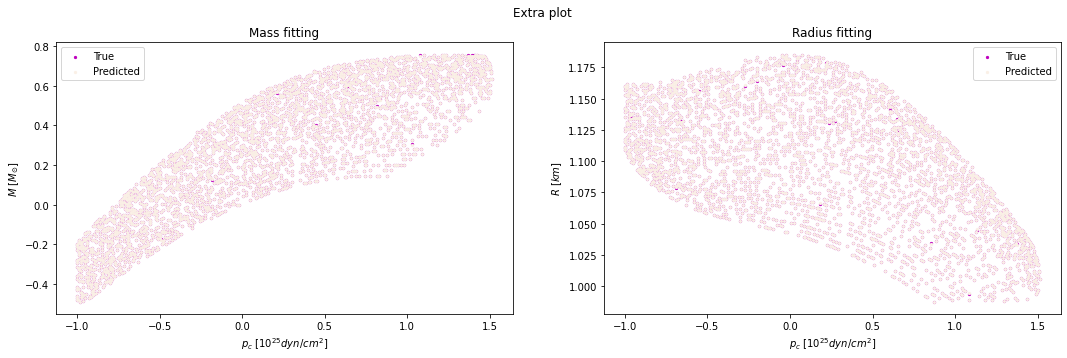

MAPE R: 	  0.000943 %
MAPE M: 	  0.004553 %


In [ ]:
plot_2D(TestingData          = TestingData,
        tr_history           = loss_lista,
        eps                  = len(loss_lista),
        bat                  = 'All',
        PD                   = PD,
        neur_list            = [25,35,25],
        activation_func_list = ['tanh','relu','tanh'],
        layers               = 3,
        extra                = False)

plot_2D(TestingData          = TestingData,
        tr_history           = loss_lista,
        eps                  = len(loss_lista),
        bat                  = 'All',
        PD                   = PD,
        neur_list            = [25,35,25],
        activation_func_list = ['tanh','relu','tanh'],
        layers               = 3,
        extra                = True)

# MAPE_R
mape_R = 100*numpy.mean(numpy.abs((10**TestingData.R.values - 10**TestingData.R_pred.values)/(10**TestingData.R.values)))


# MAPE_M
mape_M = 100*numpy.mean(numpy.abs((10**TestingData.M.values - 10**TestingData.M_pred.values)/(10**TestingData.M.values)))


print("MAPE R: \t ",round(mape_R,6) ,'%')
print("MAPE M: \t ",round(mape_M,6) ,'%')

In [ ]:
# Testing_df = pd.DataFrame({})
# Testing_df['p_c'] = test_inps.T[0]
# Testing_df['a'] = test_inps.T[0]

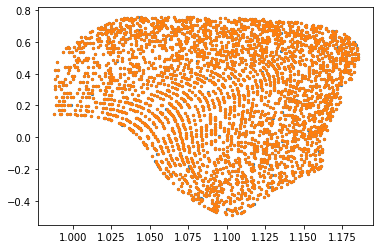

In [ ]:
x1 = test_outs.T[1]
y1 = test_outs.T[0]

x2 = pred_outs.T[1]
y2 = pred_outs.T[0]

dedomena1 = numpy.array([y1,x1]).T
dedomena1 = TargetVarScalerFit.inverse_transform(dedomena1)

dedomena2 = numpy.array([y2,x2]).T
dedomena2 = TargetVarScalerFit.inverse_transform(dedomena2)

x1 = dedomena1.T[1]
y1 = dedomena1.T[0]

x2 = dedomena2.T[1]
y2 = dedomena2.T[0]

plt.scatter (x1,y1, s = 5)

plt.scatter (x2,y2, s = 5)

plt.show()

In [ ]:
total_in = numpy.array([data.p_c.values,data.a.values]).T
total_in = PredictorScalerFit.transform(total_in)

In [ ]:
total_out = pred_model.predict(total_in)

319/319 [==============================] - 0s 1ms/step


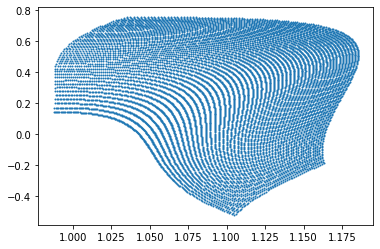

In [ ]:
total_out = TargetVarScalerFit.inverse_transform(total_out)
x1 = total_out.T[1]
y1 = total_out.T[0]
plt.scatter (x1,y1,s = 1)

plt.show()

In [ ]:
norm_df['M_pred'] = total_out.T[0]
norm_df['R_pred'] = total_out.T[1]


In [ ]:
norm_df

,p_c,M,R,a,p_n,M_pred,R_pred
0,-1.000000,-0.471098,1.110246,-0.4,0.000000,-0.471117,1.110270
1,-0.989045,-0.463526,1.108574,-0.4,0.005025,-0.463606,1.108589
2,-0.978089,-0.455974,1.106963,-0.4,0.010050,-0.456088,1.106930
3,-0.967134,-0.448443,1.105411,-0.4,0.015075,-0.448567,1.105404
4,-0.956179,-0.440950,1.103923,-0.4,0.020101,-0.441041,1.103938
...,...,...,...,...,...,...,...
10195,1.329922,0.425101,0.994600,9.2,0.979899,0.425003,0.994599
10196,1.341870,0.425021,0.993100,9.2,0.984925,0.424913,0.993099
10197,1.353818,0.424915,0.991591,9.2,0.989950,0.424805,0.991591
10198,1.365767,0.424784,0.990074,9.2,0.994975,0.424680,0.990076


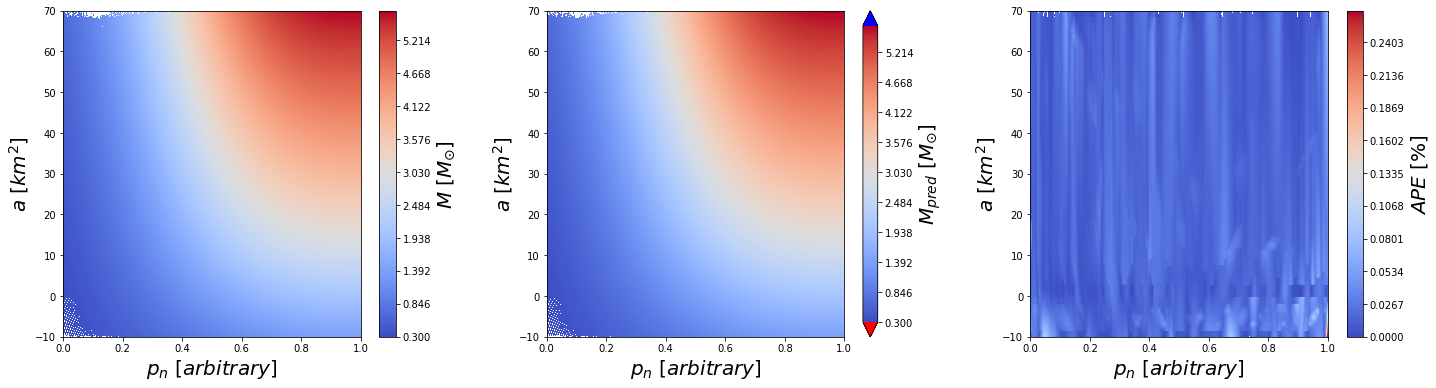

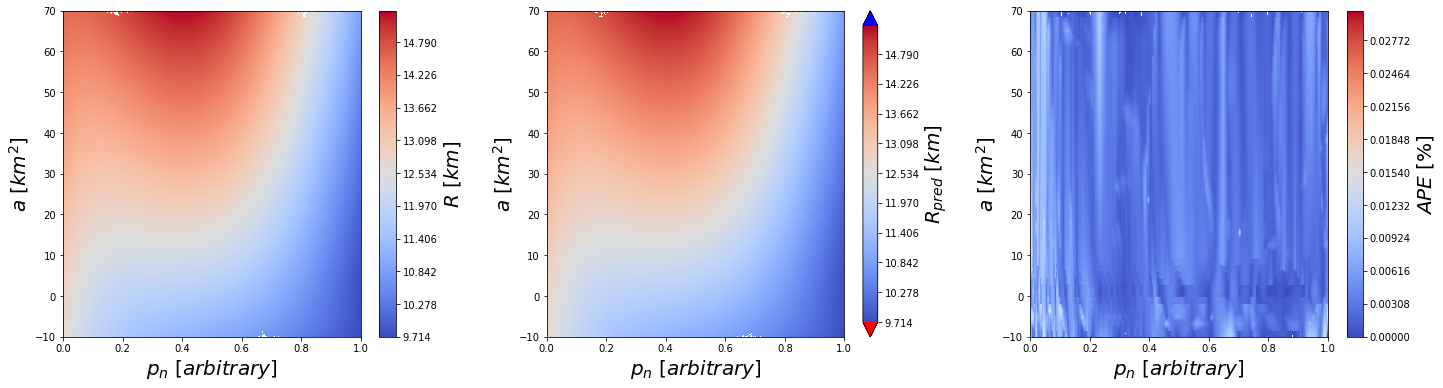

In [ ]:
contour(norm_df, 'M')
contour(norm_df, 'R')

## For boosting

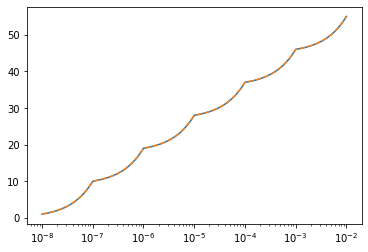

In [ ]:
def g_1(x, beta, gamma):

  for k in range(beta-gamma,0,-1):
    if abs(x) <= 10**(-beta + k):
      # continue
      # if abs(x) <= 10**(-beta + k):
      m = 10**(beta-k+1)
      y = m*x + numpy.sign(x)*9*(k-1)
  return y

  # if abs(x) <= 10**(-beta + 1):
  #   m = 10**beta
  #   y = m*x
  # elif abs(x) <= 10**(-beta + 2):
  #   m = 10**(beta - 1)
  #   y = m*x + 9
  # elif abs(x) <= 10**(-beta + 3):
  #   m = 10**(beta - 2)
  #   y = m*x + 9*2
  # elif abs(x) <= 10**(-beta + 4):
  #   m = 10**(beta - 3)
  #   y = m*x + 9*3
  # elif abs(x) <= 10**(-gamma):
  #   m = 10**(beta - (gamma + 1))
  #   y = m*x + 9*(gamma-1)
  
  # return y


# for k in range(beta-gamma,0,-1):
#     if abs(x) <= 10**(-beta + k):
#       m = 10**(beta-k+1)
#       y = m*x + numpy.sign(x)*9*(k-1)
#   return y



def h_1(y, beta, gamma):

  for k in range(beta-gamma,0,-1):
    if abs(y) <= 10+9*(k-1):
      # continue
      # if abs(x) <= 10**(-beta + k):
      m = 10**(beta-k+1)
      x = (y - numpy.sign(y)*9*(k-1))/m# + numpy.sign(y)*10**(-beta+k)
  return x

  # x0 = 0.001
  # y0 = 1000*x0
  # if x <= -x0:
  #   c = 1e-2
  #   return c*(x+x0) - y0
  # elif x <= x0:
  #   c = 1e3
  #   return c*x
  # else:
  #   c = 1e-2
  #   return c*(x-x0) + y0

beta  = 8
gamma = 2
xs = numpy.logspace((-beta),-gamma, 1000)

ys = []
for xi in xs:
    ys.append(g_1(xi,beta,gamma))
ys = numpy.array(ys)
plt.semilogx(xs, ys)

xs = []
for yi in ys:
    xs.append(h_1(yi,beta,gamma))
xs = numpy.array(xs)
plt.semilogx(xs, ys, '--')
plt.show()

In [ ]:
data['M_pred'] = y1
data['R_pred'] = x1
data['dM']     = data['M'] - data['M_pred']
data['dR']     = data['R'] - data['R_pred']

# c = 1e-3
# data['dM_tr'] = g_1(data['dM'], c)
# data['dR_tr'] = g_1(data['dR'], c)

# data['dM_abs']     = numpy.abs(data['dM'])
# data['dR_abs']     = numpy.abs(data['dR'])

# data['dM_tr']  = 10**(2+100*data['dM_abs'])-10**2
# data['dR_tr']  = 10**(2+100*data['dR_abs'])-10**2
data

,p_c,M,R,a,M_pred,R_pred,dM,dR,dM_tr,dR_tr
0,0.610097,0.503725,1.102083,26.8,0.503695,1.102078,3.033628e-05,5.498086e-06,0.016258,0.004554
1,-0.647791,-0.088031,1.115750,26.8,-0.088007,1.115747,-2.470850e-05,2.870406e-06,-0.033216,0.014299
2,0.861674,0.543305,1.080426,26.8,0.543313,1.080425,-7.863734e-06,9.209297e-07,-0.020755,0.016692
3,-0.094321,0.252778,1.122370,26.8,0.252773,1.122366,5.382741e-06,3.205616e-06,-0.014726,-0.007076
4,0.169836,0.373166,1.121240,26.8,0.373172,1.121240,-6.621805e-06,-6.618558e-07,0.007676,0.010352
...,...,...,...,...,...,...,...,...,...,...
195,1.389987,0.571475,1.014378,26.8,0.571475,1.014366,2.929794e-08,1.192946e-05,0.013355,0.013346
196,0.396256,0.451116,1.114424,26.8,0.451034,1.114406,8.238320e-05,1.806843e-05,-0.024838,0.010904
197,1.100673,0.563386,1.053698,26.8,0.563409,1.053701,-2.356551e-05,-2.830668e-06,-0.018262,-0.008188
198,0.786201,0.533691,1.087662,26.8,0.533713,1.087664,-2.183709e-05,-2.043400e-06,0.012235,-0.009293


In [ ]:
def g_2(x,a):
  return numpy.sign(x)*abs(x)**(1/a)

def h_2(y,a):
  return numpy.sign(y)*abs(y)**a

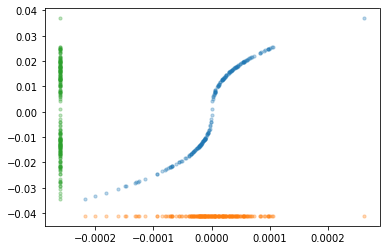

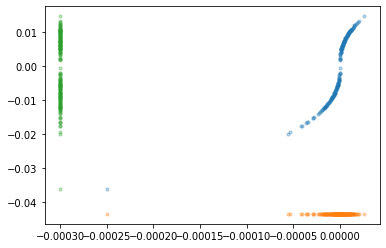

In [ ]:
pow = 2.5
pow_M = pow
pow_R = pow

minimu_M = min(numpy.abs(data.dM))
maximu_M = max(numpy.abs(data.dM))
beta_M = -(int(numpy.log10(minimu_M))-1)
gamma_M = -(int(numpy.log10(maximu_M))+1)

target_M = []
for dms in data.dM.values:
  # target_M.append(g_1(dms, beta_M, gamma_M))
  target_M.append(g_2(dms, pow_M))

s = 10
alph = 0.3
plt.scatter(data.dM, target_M, s = s, alpha = alph)
plt.scatter(data.dM, numpy.zeros(len(data.dM))-abs(1.2*min(target_M)), s = s, alpha = alph)
plt.scatter(numpy.zeros(len(data.dM))-abs(1.2*min(data.dM)), target_M, s = s, alpha = alph)
plt.show()


minimu_R = min(numpy.abs(data.dR))
maximu_R = max(numpy.abs(data.dR))
beta_R = -(int(numpy.log10(minimu_R))-1)
gamma_R = -(int(numpy.log10(maximu_R))+1)

target_R = []
for drs in data.dR.values:
  # target_R.append(g_1(drs, beta_R, gamma_R))
  target_R.append(g_2(drs, pow_R))

plt.scatter(data.dR, target_R, s = s, alpha = alph)
plt.scatter(data.dR, numpy.zeros(len(data.dR))-abs(1.2*min(target_R)), s = s, alpha = alph)
plt.scatter(numpy.zeros(len(data.dR))-abs(1.2*min(data.dR)), target_R, s = s, alpha = alph)
plt.show()

In [ ]:
data['dM_tr'] = target_M
data['dR_tr'] = target_R

In [ ]:
X_train_n, X_test_n, y_train_n, y_test_n, PredictorScalerFit_n, TargetVarScalerFit_n, data_n = prepare( data       = data,
                                                                                                        Predictors = ['p_c'],
                                                                                                        TargetVariable = ['dM_tr','dR_tr'],
                                                                                                        scale      = True,
                                                                                                        talk       = True)

(140, 1)
(140, 2)
(60, 1)
(60, 2)


2/2 [==============================] - 0s 4ms/step
L2-error norm: 2.582631322647952


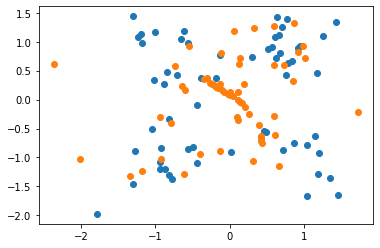


History


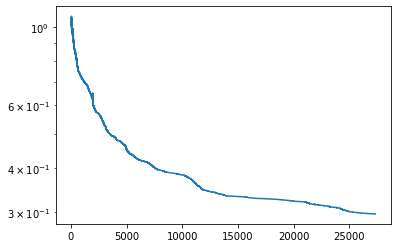

In [ ]:
# use float64 by default
tf.keras.backend.set_floatx("float64")

# prepare training data

inps = X_train_n
outs = y_train_n

# prepare prediction model, loss function, and the function passed to L-BFGS solver
pred_model_n = tf.keras.Sequential(
    [tf.keras.Input(shape=[1,]),
      tf.keras.layers.Dense(40, "relu"),
      tf.keras.layers.Dense(40, "relu"),
      tf.keras.layers.Dense(40, "relu"),
      tf.keras.layers.Dense(2, None)])


loss_fun_n = tf.keras.losses.MeanSquaredError()
func_n = function_factory(pred_model_n, loss_fun_n, inps, outs)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func_n.idx, pred_model_n.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func_n, initial_position=init_params, max_iterations=10000)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func_n.assign_new_model_parameters(results.position)

# do some prediction
test_inps = X_test_n
test_outs = y_test_n
pred_outs = pred_model_n.predict(test_inps)
err = numpy.abs(pred_outs-test_outs)
print("L2-error norm: {}".format(numpy.linalg.norm(err)/numpy.sqrt(11)))

# plot figures
x1 = test_outs.T[1]
y1 = test_outs.T[0]
plt.scatter (x1,y1)
x2 = pred_outs.T[1]
y2 = pred_outs.T[0]
plt.scatter (x2,y2)

plt.show()

# plt.scatter(inps, outs, "Exact solution", "ext_soln.png")
# plot_helper(inps, pred_outs, "Predicted solution", "pred_soln.png")
# plot_helper(inps, err, "Absolute error", "abs_err.png")
# pyplot.show()

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
# print(*func.history, sep='\n')
loss_lista_n = []
for metr in func_n.history:
  loss_lista_n.append(float(metr))
plt.semilogy(loss_lista_n)

plt.show()

7/7 [==============================] - 0s 2ms/step


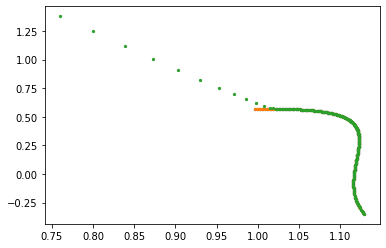

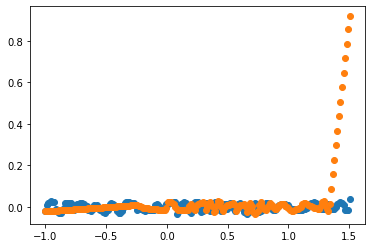

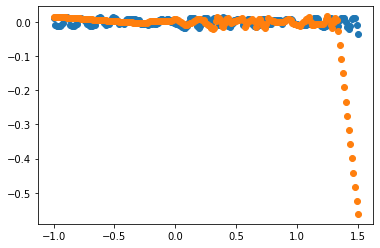

In [ ]:
new_in = numpy.array([data.p_c.values]).T

new_in = PredictorScalerFit.transform(new_in)
dedomena_1 = pred_model.predict(new_in)
dedomena_1 = TargetVarScalerFit.inverse_transform(dedomena_1)

new_in = PredictorScalerFit_n.transform(new_in)
dedomena_2 = pred_model_n.predict(new_in)
dedomena_2 = TargetVarScalerFit_n.inverse_transform(dedomena_2)


# minimu_M = min(numpy.abs(dedomena_2.T[0]))
# maximu_M = max(numpy.abs(dedomena_2.T[0]))
# beta_M = -(int(numpy.log10(minimu_M))-1)
# gamma_M = -(int(numpy.log10(maximu_M))+1)

# minimu_R = min(numpy.abs(dedomena_2.T[1]))
# maximu_R = max(numpy.abs(dedomena_2.T[1]))
# beta_R = -(int(numpy.log10(minimu_M))-1)
# gamma_R = -(int(numpy.log10(maximu_M))+1)

dok_M = []
dok_R = []
pow = 2.5
for metr in range(len(dedomena_2.T[0])):
  dok_M.append(h_2(dedomena_2.T[0][metr],pow))
  dok_R.append(h_2(dedomena_2.T[1][metr],pow))
  # dok_M.append(h_1(dedomena_2.T[0][metr],beta_M, gamma_M))
  # dok_R.append(h_1(dedomena_2.T[1][metr],beta_R, gamma_R))

dok = numpy.array([dok_M,dok_R]).T

dedomena = dedomena_1 + dok


# signs = numpy.array([numpy.sign(data.dM.values),numpy.sign(data.dR.values)]).T
# dedomena = dedomena_1 + signs*(numpy.log10(dedomena_2 + 10**2) - 2)/100

# dedomena = dedomena_1 + (dedomena_2)/1000

x1, y1 = data.R.values, data.M.values
x2, y2 = dedomena_1.T[1], dedomena_1.T[0]
x3, y3 = dedomena.T[1], dedomena.T[0]

plt.scatter(x1, y1, s = 5)
plt.scatter(x2, y2, s = 5)
plt.scatter(x3, y3, s = 5)
plt.show()

plt.scatter(data.p_c,data.dM_tr)
plt.scatter(data.p_c,dedomena_2.T[0])
plt.show()

plt.scatter(data.p_c,data.dR_tr)
plt.scatter(data.p_c,dedomena_2.T[1])
plt.show()

In [ ]:
# MAPE_R
mape_R = 100*numpy.mean(numpy.abs((10**x1 - 10**x2)/(10**x1)))
mape_R_boost = 100*numpy.mean(numpy.abs((10**x1 - 10**x3)/(10**x1)))

# MAPE_M
mape_M = 100*numpy.mean(numpy.abs((10**y1 - 10**y2)/(10**y1)))
mape_M_boost = 100*numpy.mean(numpy.abs((10**y1 - 10**y3)/(10**y1)))

print("MAPE for original: \t ",round(mape_R,6)  , '% \t' , round(mape_M,6)  , '%')
print("MAPE for boost: \t ",   round(mape_R_boost,6), '% \t' , round(mape_M_boost,6), '%')

MAPE for original: 	  0.002268 % 	 0.009495 %
MAPE for boost: 	  1.033389 % 	 8.334591 %


In [ ]:
(mape_R+mape_M)/2

0.0058814977903986175